DO NOT RESTART AND CLEAR OUTPUT!! NEED the graphs at the end!!


**Question**: How  does the solution space relate to the number of baselines and to spacing of antenas.  
**Note**: We do not consider the solution path here as we do not implement LMA  

**Objectives**  
Vary #Baselines and Spacing  
Measure the with of global valley  
Graph it w.r.t #Baselines  
Graph it w.r.t Baseline spacing  
Write a report  

I want to plot spath onto sol-space of diff num of ants

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as ssig
import random
import ProjectPacks as pp
import ProjectFuncs as pf

%matplotlib inline
plt.rcParams['figure.figsize'] = (18, 6)  #spreads out plot surface for better visualization

from IPython.display import HTML 
HTML('../style/course.css') #apply general CSS

from IPython.display import HTML
HTML('../style/code_toggle.html')

In [9]:
## temporary file we write different array configurations out to. 
fout='temp_arr.txt'
 
def create_arrayfile(arr=[70,80,100,130,170,220,300],freq=1.4e9):
    with open(fout,'w') as f:
        f.write("{} {} \n".format("Num_Array: ",len(arr)))
        atxt=''
        for i,a in enumerate(arr): 
            atxt=atxt+' '+str(a)
            if i<len(arr)-1: atxt=atxt+','
        print(atxt)
        f.write("{} {} \n".format("Centre_Dist: ",atxt ) )
        f.write("{} {} \n".format("Centre_Freq: ",freq))


In [10]:
def get_res(u_mat,v_mat,d): #only making A constant to save time

    rr_constA= np.empty((timeslots,timeslots))

    for a in range(timeslots):
        for b in range(timeslots):

            x_r= np.array([[L[a],M[b],x_true[0,2]]])
            rr_constA[a,b]= np.square(np.linalg.norm(pf.modfunc_res(x_r,u_mat,v_mat,d)))/(int(len(u_mat)*(len(u_mat)-1)/2))

    Minimum_A= np.unravel_index(np.argmin(rr_constA),rr_constA.shape)
    print("Minimum value of (L,M) is at {} and is: ".format(Minimum_A),rr_constA[Minimum_A])

    return rr_constA, Minimum_A


def find_nearest(array): 
    
    loc_maxs= ssig.argrelmax(array)
    glob_min= np.argmin(array)
    
    id1 = (np.abs(loc_maxs[0]-glob_min)).argmin()
    id2 = ((loc_maxs[0]-glob_min)>0).argmax()
        
    return loc_maxs[0][id1],loc_maxs[0][id2]
    
# %prun get_res()

In [11]:
## trying out real case first
def levenberg_marquardt(data, u_ant, v_ant, x, r_func, j_func, maxit=100, lamda=1, K=10, eps1=1e-6, eps2=1e-6):
    """
    Returns a vector containing the optimal parameter values found by the algorithm.
    
    INPUTS:
    data      Vector of measured values.
    x         Vector of parameters. (S,3)
    r_func    Function which generates the residual vector. (1,t*nb)
    j_func    Function which generates the (Conjugate of) Jacobian & the Hessian. (S*3,t*nb) & (S*3,S*3) 
    maxit     Maximum number of iterations.
    lamda     Initial value of tuning parameter.
    K         Initial value of retuning factor.
    eps1      First tolerance parameter - triggers when residual is below this number.
    eps2      Second tolerance parameter - triggers when relative changes to the parameter
              vector are below this number.
    """
    
    #Initialises some important values and stores the original lamda value.
    r = r_func(x, u_ant, v_ant, data)
    #print("Shape of residual vec: ", np.shape(r))
    
    old_chi = np.linalg.norm(r)
    olamda = lamda
    it = 0

    chiplot=[]
    chiplot.append(old_chi)
    
    solpath= x
    
    while True:
        solpath= np.vstack((solpath,x))  
        #Heavy lifting portion of the algorithm. Computes the parameter update.
        #This is just the implementation of the mathmatical update rule.
        JH,JHJ = j_func(x,u_ant,v_ant)
        
        JHJdiag = np.diag(np.diag(JHJ))
        #this says there is a different D for each timeslot
        #lamda = 1 if (it%2==0) else 0
        JHJinv= np.linalg.pinv(JHJ+lamda*JHJdiag)
        JHr = JH.dot(r)
        
        delta_x = JHJinv.dot(JHr)        
        x += delta_x.real.reshape((len(x),3))
        
        #solpath= np.vstack((solpath,x))  
        
        #Convergence tests. If a solution has been found, returns the result.
        #The chi value is the norm of the residual and is used to determine
        #whether the solution is improving. If the chi value is sufficiently 
        #small, the function terminates. The second test checks to see whether
        #or not the solution is improving, and terminates if it isn't.
        
        r = r_func(x, u_ant, v_ant, data)
        new_chi = np.linalg.norm(r)
        chiplot.append(new_chi)
        
        if new_chi < eps1:
            return x,chiplot,solpath
        elif np.linalg.norm(delta_x.real) < eps2*(np.linalg.norm(x) + eps2):
            return x,chiplot,solpath
        
        #Tuning stage. If the parameter update was good, continue and restore lamda.
        #If the update was bad, scale lamda by K and revert last update.
        
        if new_chi > old_chi:
            x -= delta_x.real.reshape((len(x),3))
            lamda = lamda*K
        else:
            old_chi = new_chi
            lamda = olamda
            
        #If the number of iterations grows too large, return the last value of x.
        
        it += 1
            
        if it >= maxit:
            return x,chiplot,solpath


In [12]:
#import profile
timeslots= 300
t = np.arange(0, 5, 5/timeslots)          #The points at which we will be taking our "measurements"

x_true = np.radians([[0.34,0.45,4.]])          #The true (starting) values of our parameter vector (for alg).

L= np.radians(np.arange(-1,1,2/timeslots))
M= np.radians(np.arange(-1,1,2/timeslots))
A= np.radians(np.arange(1,11,10/timeslots))

In [13]:
#from ipywidgets import interact

## shows what happens when both number of ants increases and baseline length increases

def solpath_per_NumAndLen(Max_Num_of_Ants,configs_func= lambda x: 3*(np.square(x)+4)):
    
    x_= np.arange(1,Max_Num_of_Ants+1)
    array_dist_configs= configs_func(x_)
    
    create_arrayfile(arr= array_dist_configs)
    A_mod,l_mod,m_mod,ut,vt,arrayHxpos= pp.formatSParams(fout,'Field_Profile.txt',td=timeslots)
    
    L_widths= []
    for i in range(3,Max_Num_of_Ants+1,4):
    
        u_t= ut[:i,:i]
        v_t= vt[:i,:i]

        nbl= int(len(u_t)*(len(u_t)-1)/2)
        noise = 0.000*np.random.normal(size=(timeslots*2*nbl)) 
        
        d= pf.modfunc(x_true,u_t,v_t)
        x_mod = np.radians([[0.5,-0.5,5.]])
        x_start= x_mod.copy()
        
        solved_x,cplot,spath = levenberg_marquardt(d,u_t,v_t,x_mod,pf.modfunc_res,pf.modfunc_jac)

        RR_const= get_res(u_t,v_t,d)
        Lmin_slice = RR_const[0][:,RR_const[1][1]]
        
        near_maxs= find_nearest(Lmin_slice) #returns index of local maxima nearest global minimum
        nm_range = near_maxs[1]-near_maxs[0]
        
        print("Local peaks nearest to the global minimum are at positions: \n",near_maxs)

        plt.subplot(221)
        plt.imshow(np.flipud(RR_const[0]), extent=[-1,1,-1,1])
        plt.plot(x_true[0,1]*180/np.pi,x_true[0,0]*180/np.pi,'ro',spath[1:,1]*180/np.pi,spath[1:,0]*180/np.pi,'k',lw=1) #changed x_true[0] to x_true[0,0]
        plt.plot(solved_x[0,1]*180/np.pi, solved_x[0,0]*180/np.pi, 'kx',lw=1)
        plt.colorbar()
        plt.grid()
        plt.xlabel("m_values in degrees")
        plt.ylabel("l_values in degrees")
        plt.title("Contour mapping of L,M, \n constant A with {} ants".format(i))
        plt.legend(["Global minimum","Solution path"],loc="lower right")
        
#         plt.subplot(222)
#         plt.plot(cplot,'g',linewidth= 3.0)
#         plt.xlabel("Iteration")
#         plt.ylabel(r'$\chi^2$'+" -error")
#         plt.title("Chi-squared error curve per iteration \n of LMA for {} antennas".format(i))
#         plt.show()
                            
        plt.subplot(222)
        plt.plot(L*180/np.pi,Lmin_slice, 'b', x_true[0,0]*180/np.pi,[0],'ro') #changed x_true[0] to x_true[0,0]
        
        plt.plot(L[near_maxs[0]]*180/np.pi,Lmin_slice[near_maxs[0]],"g^") #left nearest (to global min) local max
        plt.plot(L[near_maxs[1]]*180/np.pi,Lmin_slice[near_maxs[1]],"g^") #right nearest local max
        
        # illustration of width of global valley
        plt.plot(L[near_maxs[0]:near_maxs[1]+1]*180/np.pi,np.max(Lmin_slice)*np.ones(nm_range+1), "k")
        
        plt.title("Slice along L against true M for \n {} ants - normalized over #(baselines)".format(i))
        plt.grid("on")
        plt.xlabel("m = 0.45 and l in [-1,1] (in degrees)")
        plt.ylabel("Residual norm")
        
        plt.show()
        
        L_widths.append(L[near_maxs[1]]-L[near_maxs[0]]) #in radians
        
    return L_widths #in radians


 15, 24, 39, 60, 87, 120, 159, 204, 255, 312, 375, 444, 519, 600, 687
Minimum value of (L,M) is at (201, 217) and is:  0.0010308531834
Local peaks nearest to the global minimum are at positions: 
 (136, 266)


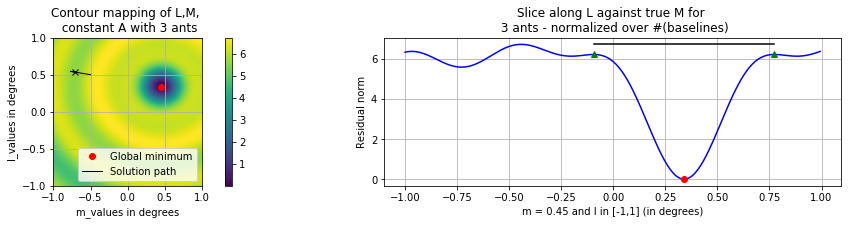

Minimum value of (L,M) is at (201, 217) and is:  0.0196994833673
Local peaks nearest to the global minimum are at positions: 
 (166, 236)


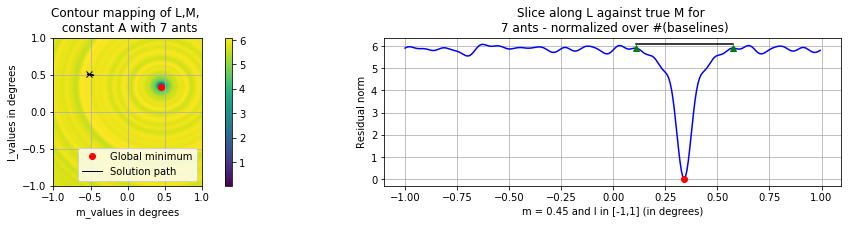

Minimum value of (L,M) is at (201, 217) and is:  0.10431255749
Local peaks nearest to the global minimum are at positions: 
 (177, 225)


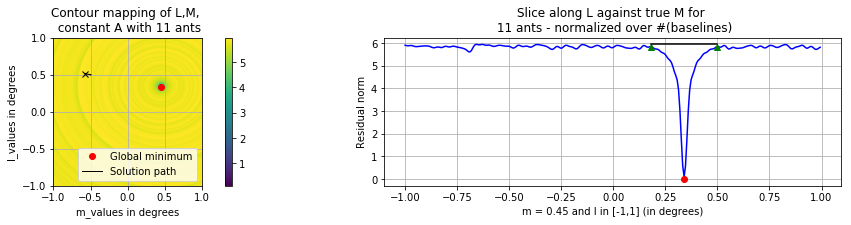

Minimum value of (L,M) is at (201, 217) and is:  0.330174351458
Local peaks nearest to the global minimum are at positions: 
 (183, 219)


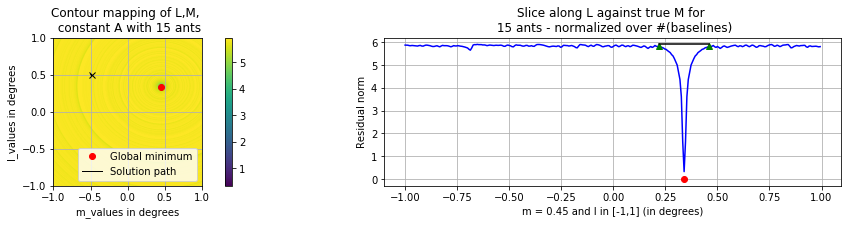

In [14]:
Ants_maxnum=15

valley_widths = solpath_per_NumAndLen(Ants_maxnum)

 15, 24, 39, 60, 87, 120, 159, 204, 255, 312, 375, 444, 519, 600, 687
Minimum value of (L,M) is at (201, 217) and is:  0.0010308531834
Local peaks nearest to the global minimum are at positions: 
 (136, 266)


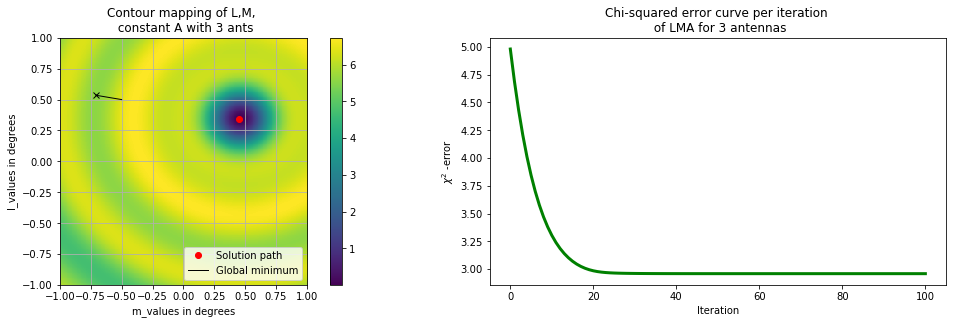

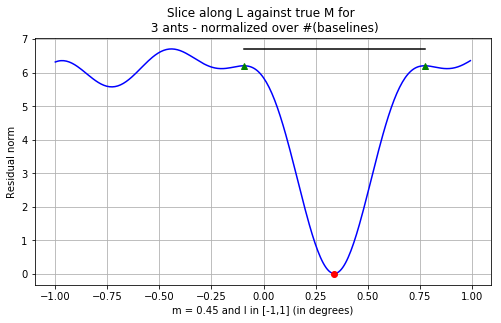

Minimum value of (L,M) is at (201, 217) and is:  0.0196994833673
Local peaks nearest to the global minimum are at positions: 
 (166, 236)


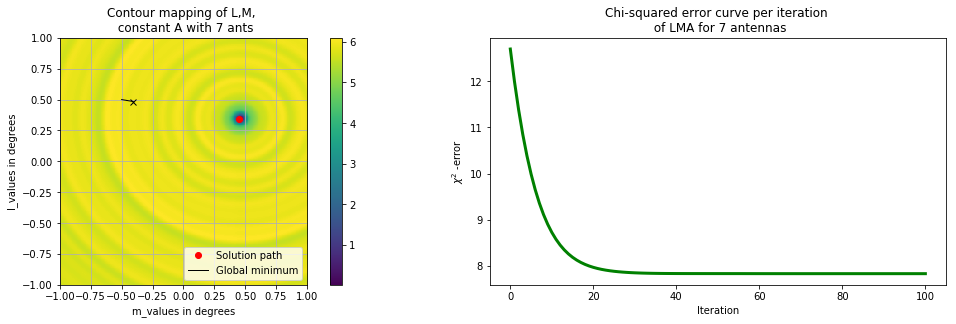

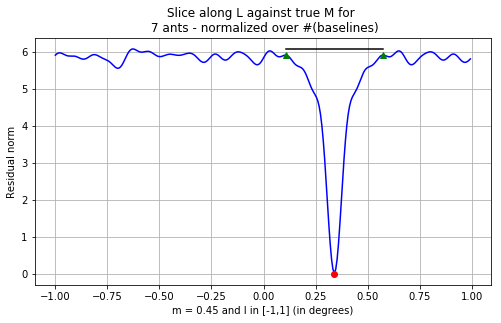

Minimum value of (L,M) is at (201, 217) and is:  0.10431255749
Local peaks nearest to the global minimum are at positions: 
 (177, 225)


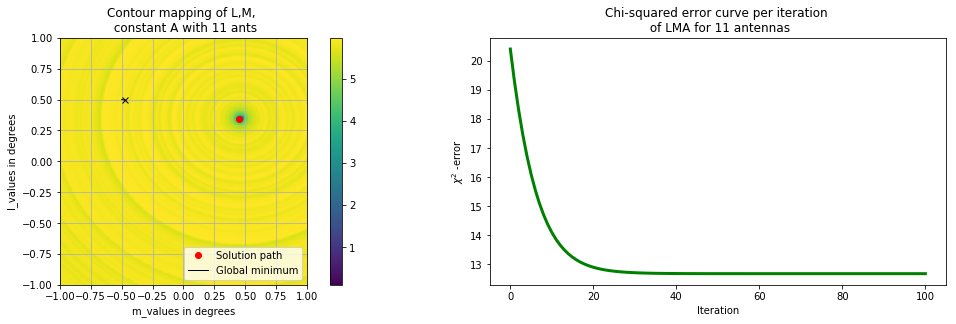

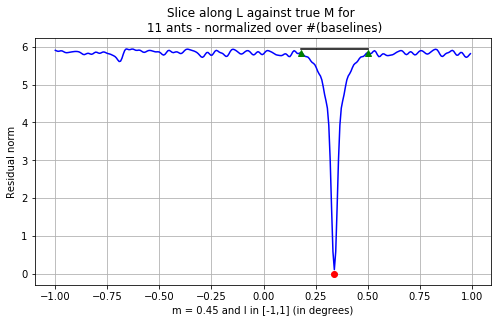

Minimum value of (L,M) is at (201, 217) and is:  0.330174351458
Local peaks nearest to the global minimum are at positions: 
 (183, 219)


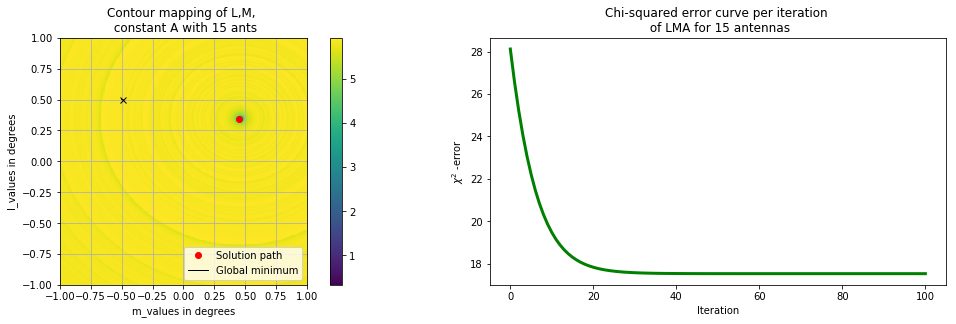

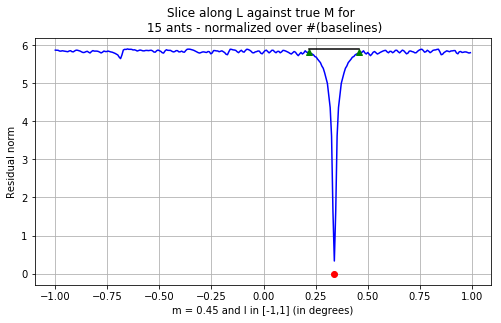

In [18]:
valley_widths = solpath_per_NumAndLen(Ants_maxnum)

 15, 24, 39, 60, 87, 120, 159, 204, 255, 312, 375, 444, 519, 600, 687
Minimum value of (L,M) is at (201, 217) and is:  0.0010308531834
Local peaks nearest to the global minimum are at positions: 
 (136, 266)


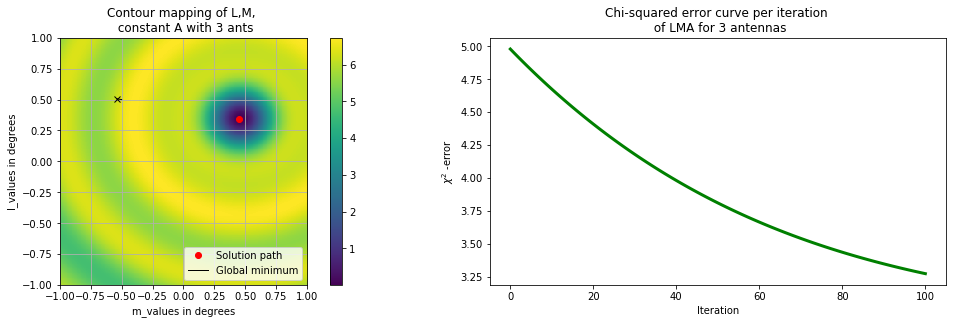

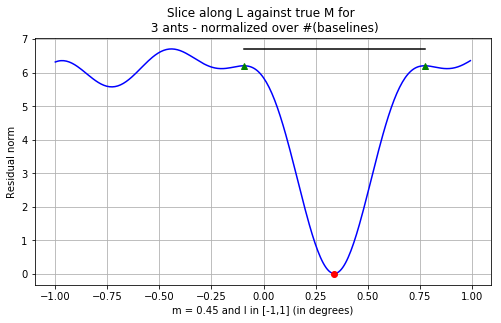

Minimum value of (L,M) is at (201, 217) and is:  0.0196994833673
Local peaks nearest to the global minimum are at positions: 
 (166, 236)


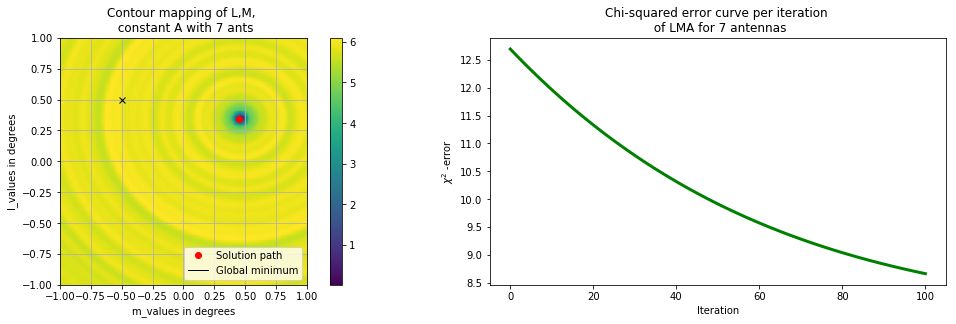

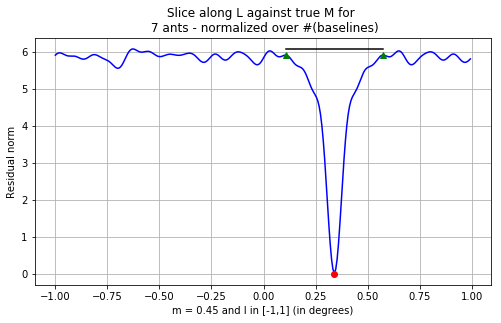

Minimum value of (L,M) is at (201, 217) and is:  0.10431255749
Local peaks nearest to the global minimum are at positions: 
 (177, 225)


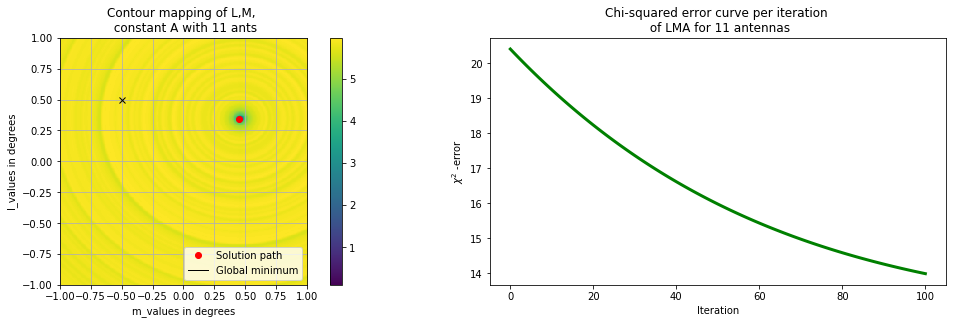

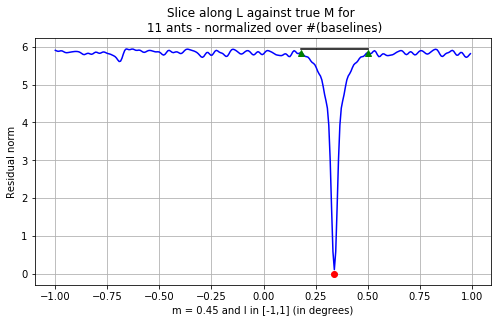

Minimum value of (L,M) is at (201, 217) and is:  0.330174351458
Local peaks nearest to the global minimum are at positions: 
 (183, 219)


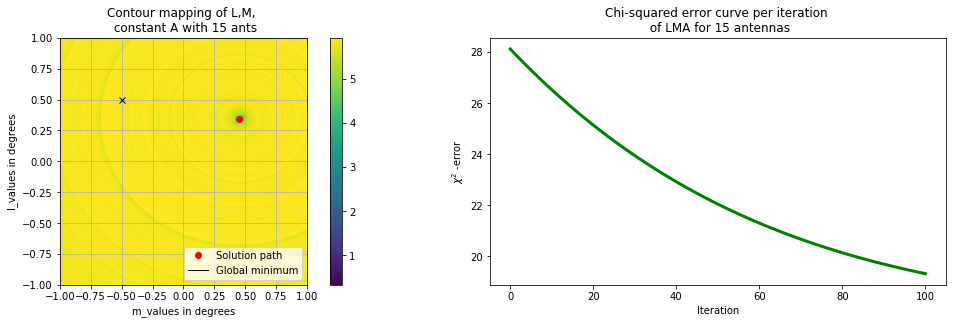

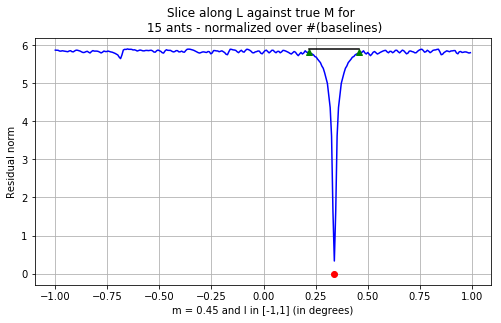

In [24]:
valley_widths = solpath_per_NumAndLen(Ants_maxnum)

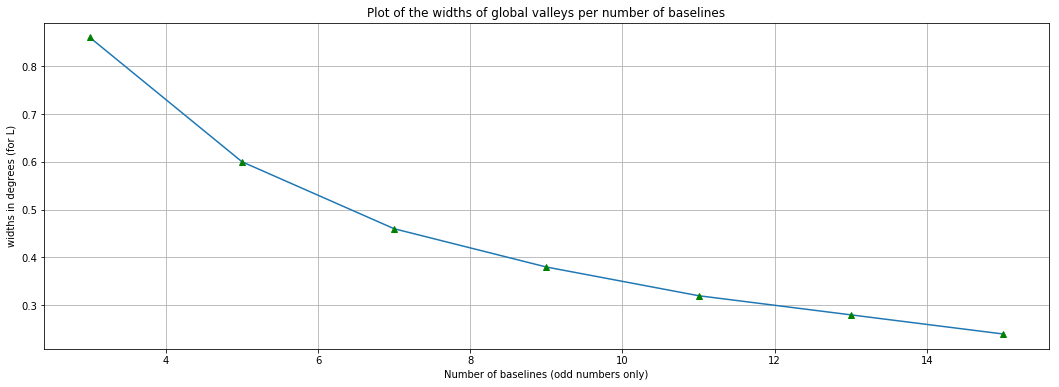

In [8]:
plt.plot(np.arange(3,Ants_maxnum+1,2),np.array(valley_widths)*180/np.pi)
plt.plot(np.arange(3,Ants_maxnum+1,2),np.array(valley_widths)*180/np.pi,"g^")
plt.title("Plot of the widths of global valleys per number of baselines")
plt.xlabel("Number of baselines (odd numbers only)")
plt.ylabel("widths in degrees (for L)")
plt.grid("on")
plt.show()

In [9]:
print(valley_widths)

[0.015009831567151247, 0.010471975511965987, 0.0080285145591739229, 0.0066322511575784594, 0.0055850536063818601, 0.0048869219055841275, 0.0041887902047863948]


In [19]:
#now for the variable baseline lengths
#arbitrarily choosing 7 Ants (lucky number 7 (idea: KAT7))
#must figure out mechanism of antenna spacing #statistical distribution maybe?

def solpath_per_lenBL(Fixed_Num_of_Ants, Num_of_configs):
        
    x_= np.arange(1,Fixed_Num_of_Ants+1)
    
    Ave_mins=[]
    L_widths= []
    for i in range(1,Num_of_configs+1):
    
        array_dist_configs= 2*i*(np.square(x_)+4)

        create_arrayfile(arr= array_dist_configs)
        A_mod,l_mod,m_mod,ut,vt,arrayHxpos= pp.formatSParams(fout,'Field_Profile.txt',td=timeslots)

        x_mod = np.radians([l_mod[0],m_mod[0],A_mod[0]])
        x_start= x_mod.copy()

        nbl= int(len(ut)*(len(ut)-1)/2)
        noise = 0.000*np.random.normal(size=(timeslots*2*nbl)) 

        d= pf.modfunc(x_true,ut,vt)

        RR_const= get_res(ut,vt,d)
        Lmin_slice = RR_const[0][:,RR_const[1][1]]
        
        #############################################################################################
        #Widths of glob_min is also narrowing
        near_maxs= find_nearest(Lmin_slice) #returns index of local maxima nearest global minimum
        nm_range = near_maxs[1]-near_maxs[0]
        
        print("Local peaks nearest to the global minimum are at positions: \n",near_maxs)
        ############################################################################################
        
        
        L_mins= ssig.argrelmin(Lmin_slice)
        
        depths= np.max(Lmin_slice)-Lmin_slice[L_mins]
        sum_loc_depths= np.sum(depths)-np.max(depths)

        Ave_mins.append(sum_loc_depths/(len(depths)-1))

        plt.subplot(221)
        plt.imshow(np.flipud(RR_const[0]), extent=[-1,1,-1,1])
        plt.plot(x_true[1]*180/np.pi,x_true[0]*180/np.pi,'ro',lw=1)
        plt.colorbar()
        plt.grid()
        plt.xlabel("m_values in degrees")
        plt.ylabel("l_values in degrees")
        plt.title("Contour mapping of L,M, constant A \n with {} ants".format(Fixed_Num_of_Ants))

        plt.subplot(222)
        
        ## must also plot UV tracks
        for k in range(len(ut)):
            for i in range(k,len(ut)):
                plt.plot(ut[k][i],vt[k][i],"r-.", ut[i][k],vt[i][k],"b-")
        
        plt.title("UV tracks of baselines")
        plt.show()
        
        plt.plot(L[L_mins]*180/np.pi,Lmin_slice[L_mins],"gx")
        plt.plot(L*180/np.pi,Lmin_slice, 'b', x_true[0]*180/np.pi,[0],'rx')
        
        #############################################################################################
        plt.plot(L[near_maxs[0]]*180/np.pi,Lmin_slice[near_maxs[0]],"g^") #left nearest (to global min) local max
        plt.plot(L[near_maxs[1]]*180/np.pi,Lmin_slice[near_maxs[1]],"g^") #right nearest local max
        
        # illustration of width of global valley
        plt.plot(L[near_maxs[0]:near_maxs[1]+1]*180/np.pi,np.max(Lmin_slice)*np.ones(nm_range+1), "k")
        
        #############################################################################################
        
        plt.title("""Investigating the slice along L against constant true M \n {} ants - 
                      normalized over #(baselines), max baseline length (in m)= {}""".format(Fixed_Num_of_Ants,i*10*Fixed_Num_of_Ants))
        plt.grid("on")
        plt.xlabel("m = 0.5 and l in [-1,1] (in degrees)")
        plt.ylabel("Residual norm")
        plt.show()
        
        
        L_widths.append(L[near_maxs[1]]-L[near_maxs[0]]) #in radians
        
    return Ave_mins, L_widths #in radians
    
    
    

 25, 36, 49, 64, 81, 100, 121
Minimum value of (L,M) is at (140, 150) and is:  1.80415986081e-27
Local peaks nearest to the global minimum are at positions: 
 (93, 187)


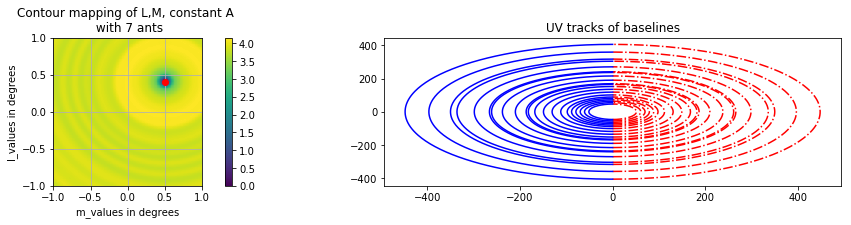

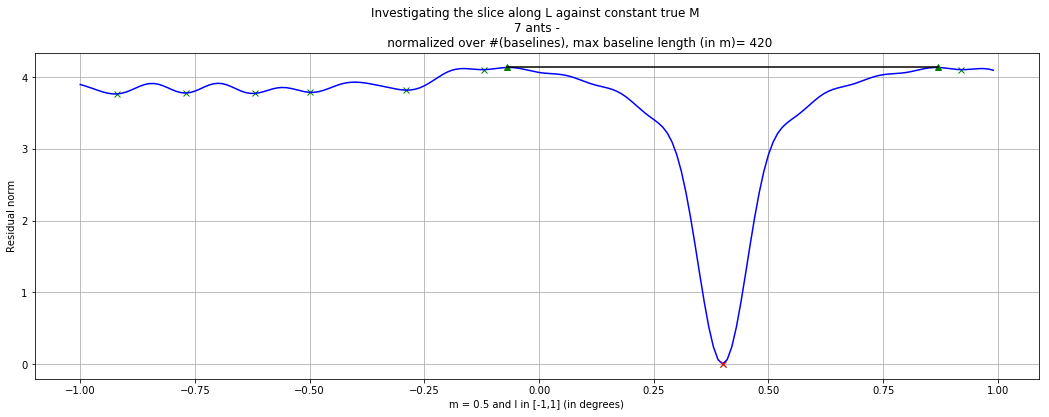

 50, 72, 98, 128, 162, 200, 242
Minimum value of (L,M) is at (140, 150) and is:  7.21649885849e-27
Local peaks nearest to the global minimum are at positions: 
 (117, 163)


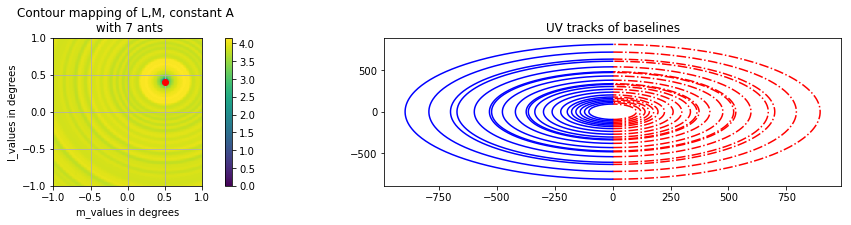

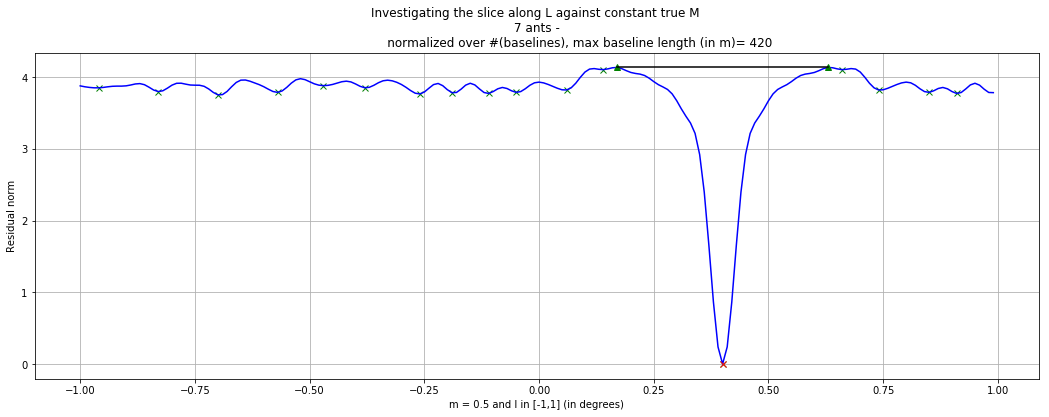

 75, 108, 147, 192, 243, 300, 363
Minimum value of (L,M) is at (140, 150) and is:  1.62607090067e-26
Local peaks nearest to the global minimum are at positions: 
 (124, 156)


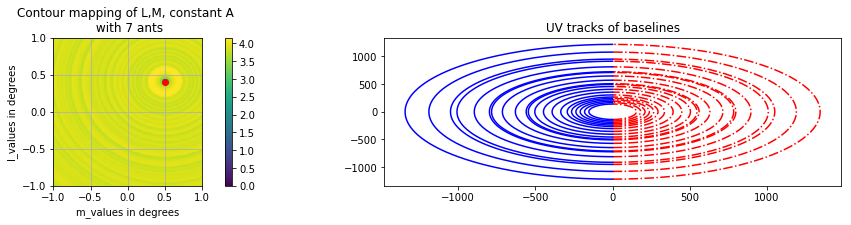

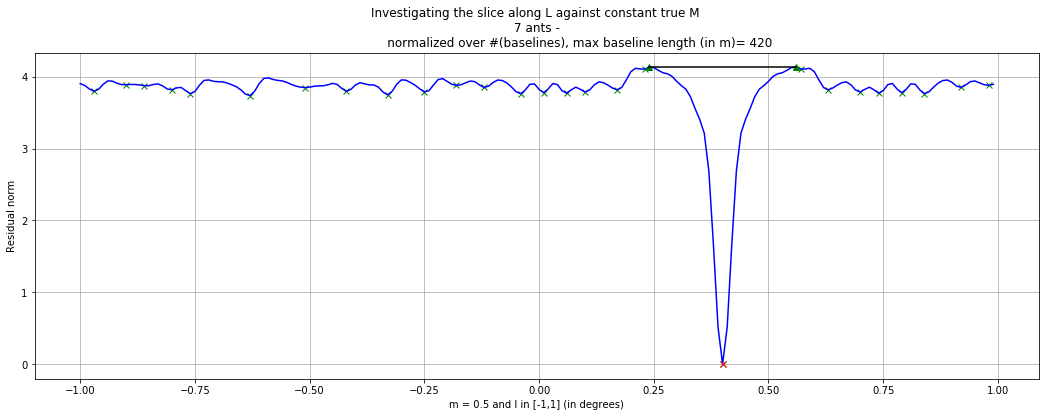

 100, 144, 196, 256, 324, 400, 484
Minimum value of (L,M) is at (140, 150) and is:  2.88659179011e-26
Local peaks nearest to the global minimum are at positions: 
 (128, 152)


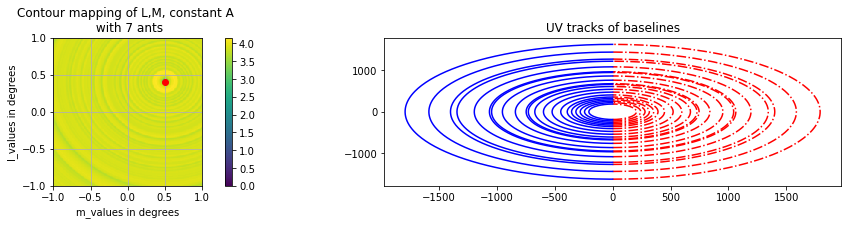

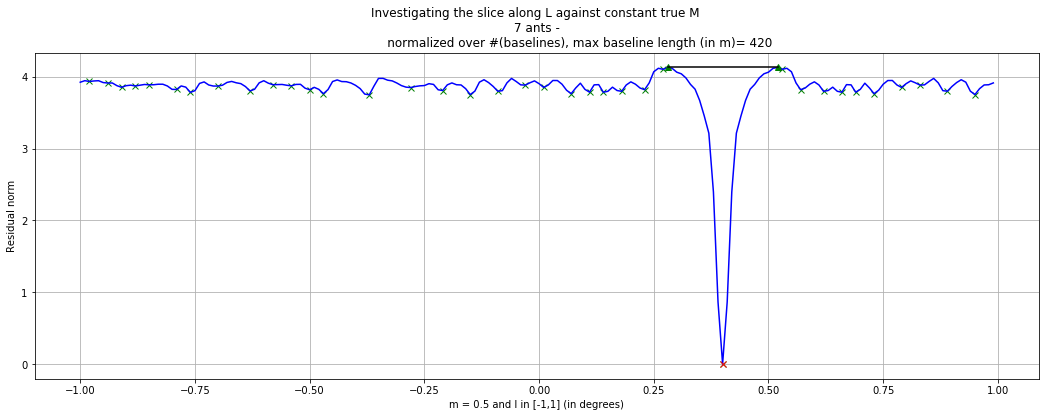

 125, 180, 245, 320, 405, 500, 605
Minimum value of (L,M) is at (140, 150) and is:  4.51280048114e-26
Local peaks nearest to the global minimum are at positions: 
 (131, 149)


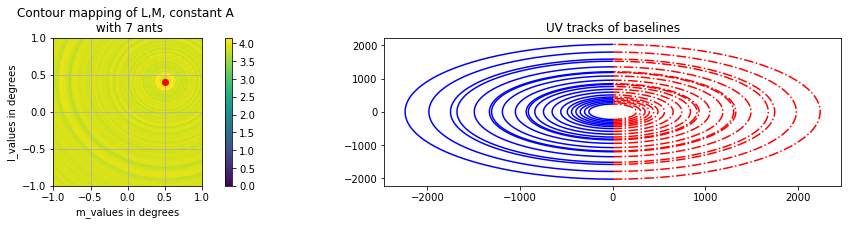

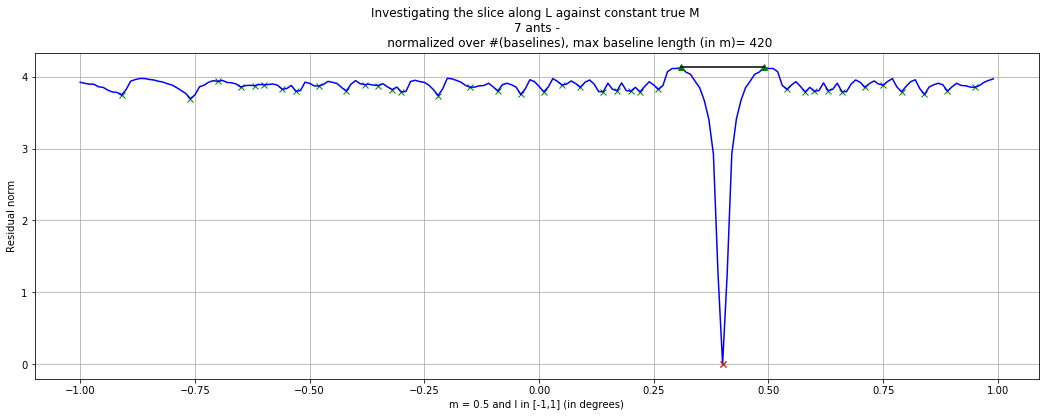

 150, 216, 294, 384, 486, 600, 726
Minimum value of (L,M) is at (140, 150) and is:  6.50428310465e-26
Local peaks nearest to the global minimum are at positions: 
 (132, 148)


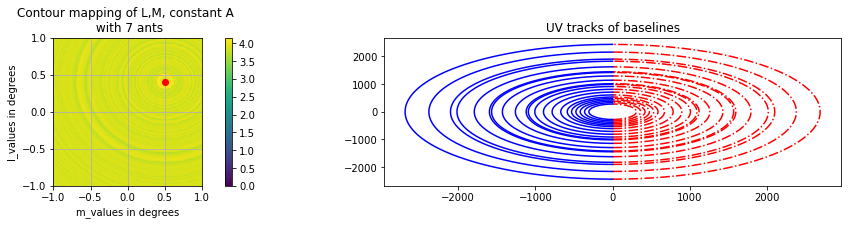

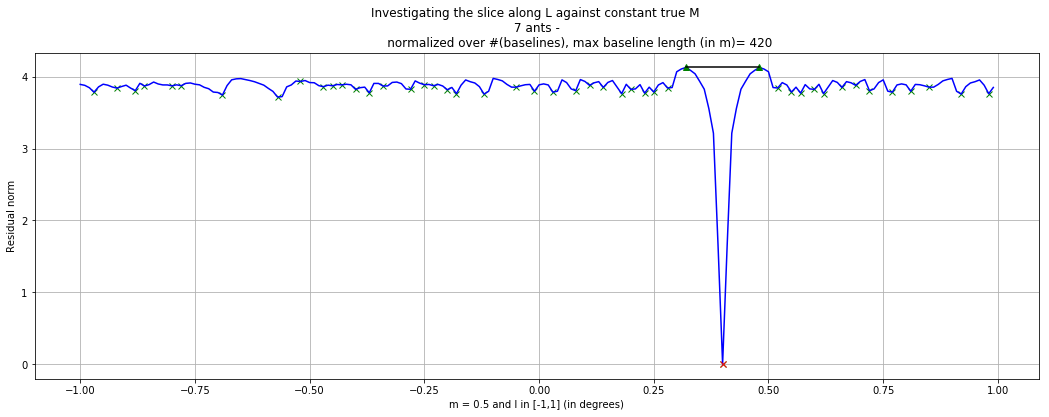

 175, 252, 343, 448, 567, 700, 847
Minimum value of (L,M) is at (140, 150) and is:  8.84270274064e-26
Local peaks nearest to the global minimum are at positions: 
 (133, 147)


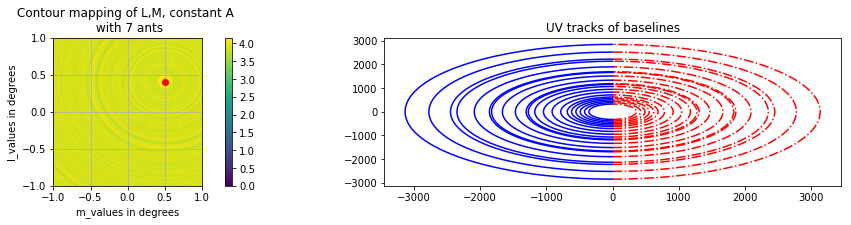

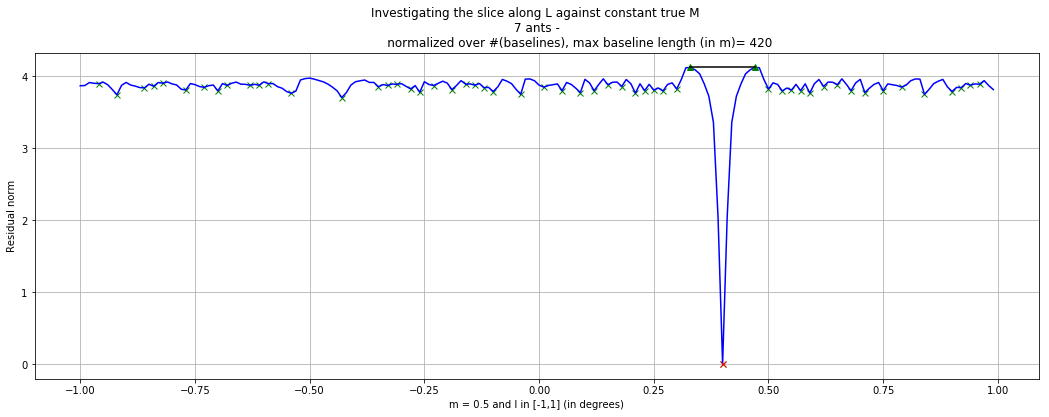

 200, 288, 392, 512, 648, 800, 968
Minimum value of (L,M) is at (140, 150) and is:  1.15465221164e-25
Local peaks nearest to the global minimum are at positions: 
 (134, 146)


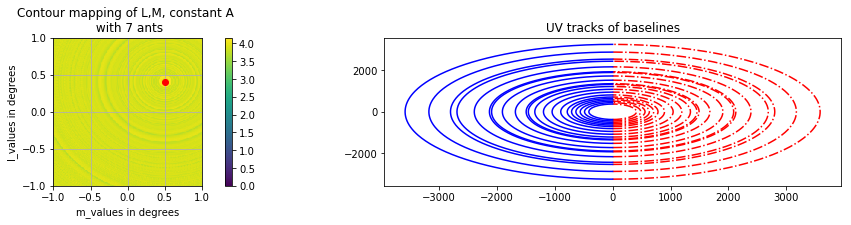

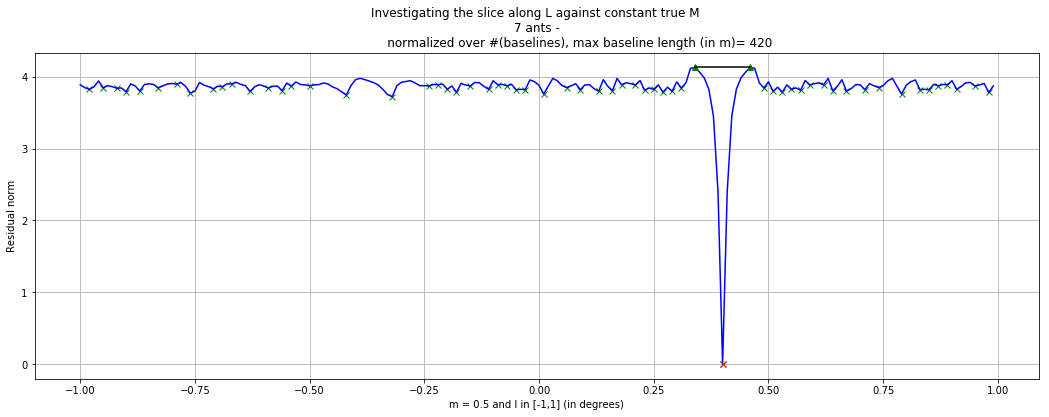

 225, 324, 441, 576, 729, 900, 1089
Minimum value of (L,M) is at (140, 150) and is:  1.45916688779e-25
Local peaks nearest to the global minimum are at positions: 
 (135, 145)


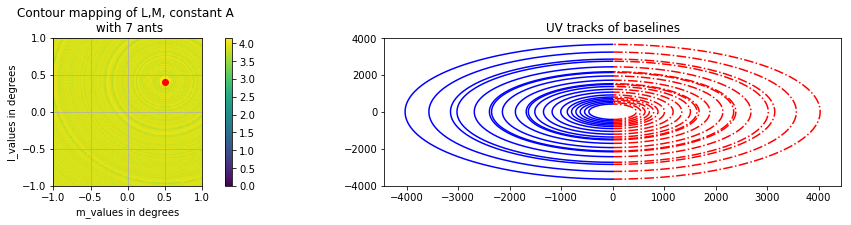

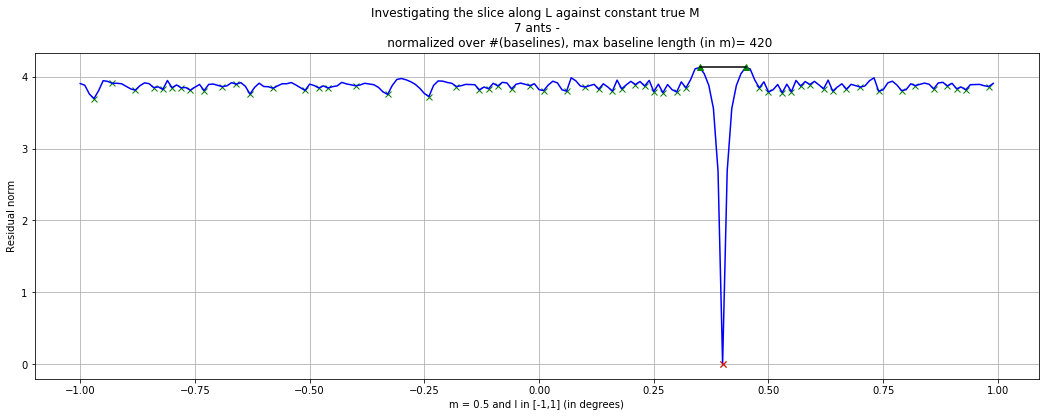

 250, 360, 490, 640, 810, 1000, 1210
Minimum value of (L,M) is at (140, 150) and is:  1.80510243791e-25
Local peaks nearest to the global minimum are at positions: 
 (135, 145)


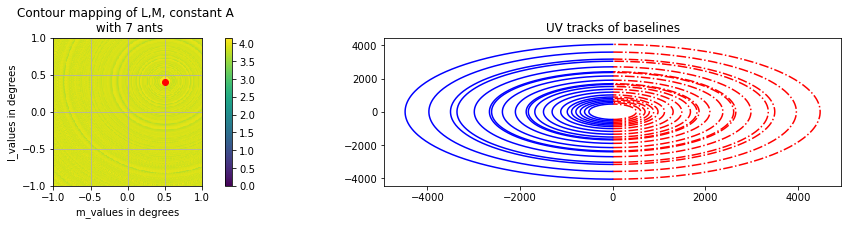

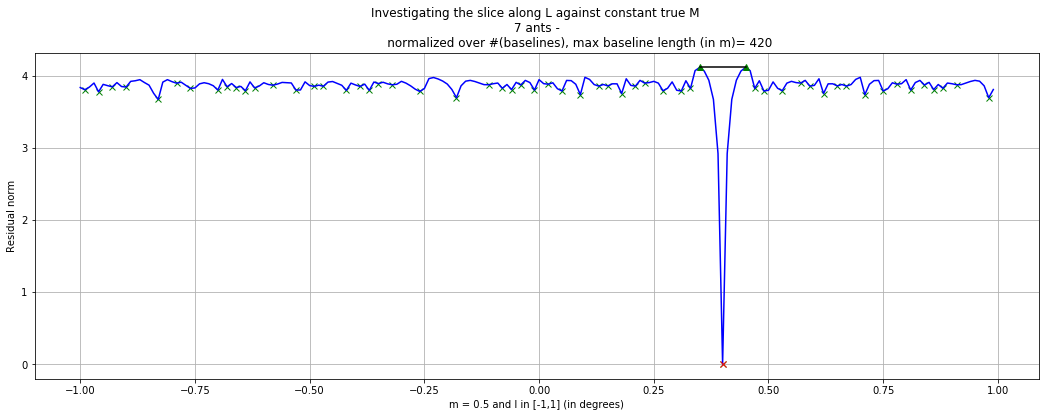

In [20]:
Aves,valley_widths= solpath_per_lenBL(7,10)

maximum baseline lengths over 10 configurations and 7 antennas: 
 [ 192  384  576  768  960 1152 1344 1536 1728 1920]


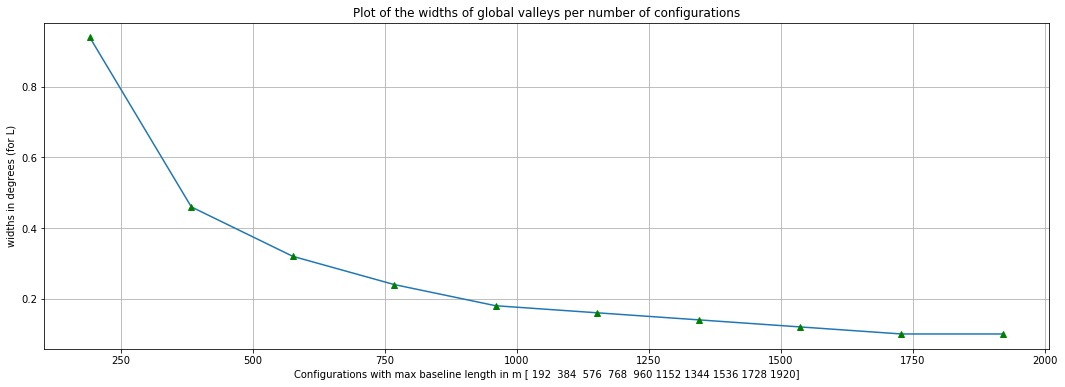

In [37]:
c = np.arange(1,10+1,1)
max_BL_lengths= 2*c*(np.square(7+4)-np.square(1+4))

print("maximum baseline lengths over 10 configurations and 7 antennas: \n",max_BL_lengths)

plt.plot(max_BL_lengths,np.array(valley_widths)*180/np.pi)
plt.plot(max_BL_lengths,np.array(valley_widths)*180/np.pi,"g^")
plt.title("Plot of the widths of global valleys per number of configurations")
plt.xlabel("Configurations with max baseline length in m {}".format(max_BL_lengths))
plt.ylabel("widths in degrees (for L)")
plt.grid("on")
plt.show()

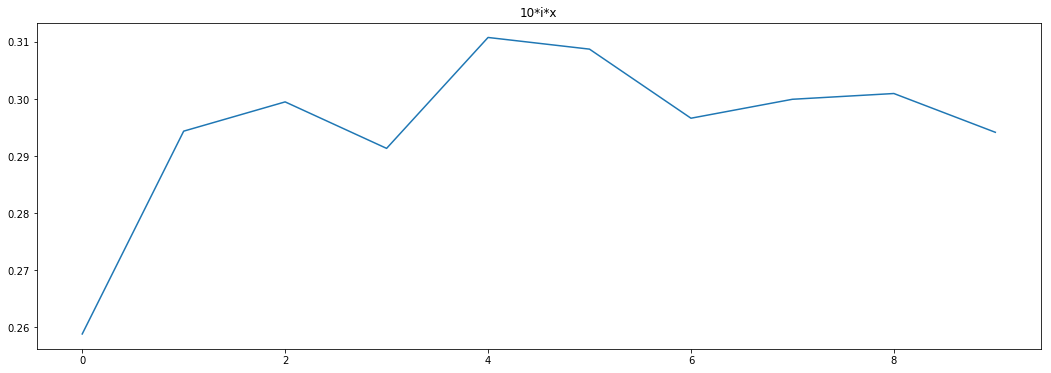

In [34]:
plt.plot(Aves)
plt.title("10*i*x")

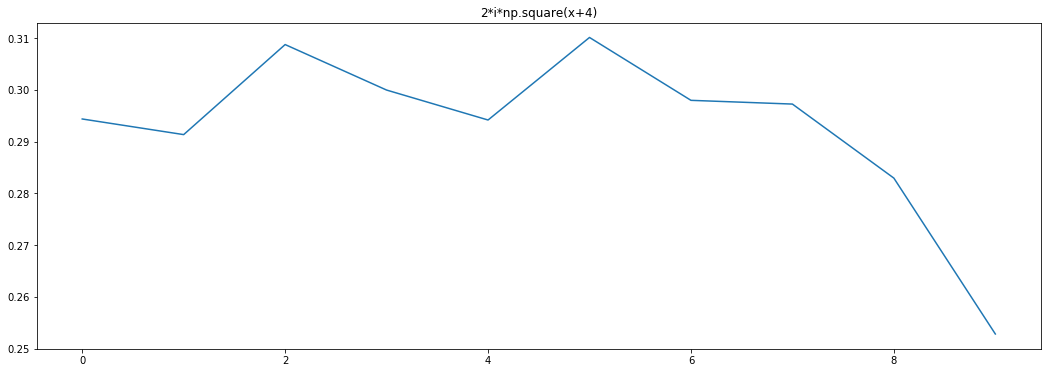

In [18]:
plt.plot(Aves)
plt.title("2*i*np.square(x+4)")

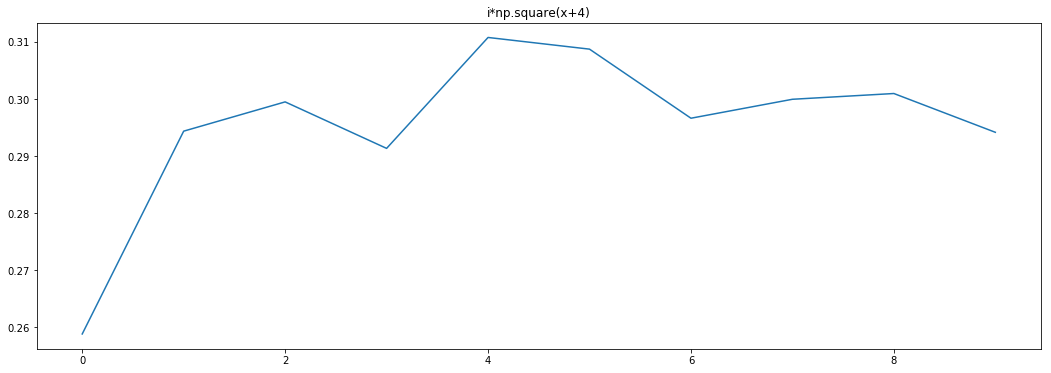

In [23]:
plt.plot(Aves)
plt.title("i*np.square(x+4)")

In [ ]:
## Varying the number of ants while keeping the max baseline length constant

def solpath_per_NumAnts(Fixed_Max_lenBL, Max_Num_of_Ants):
        
    x_= np.arange(1,Fixed_Num_of_Ants+1)
    
    Ave_mins=[]
    L_widths= []
    for i in range(1,Num_of_configs+1):
    
        array_dist_configs= 2*i*np.square(x_+4)

        create_arrayfile(arr= array_dist_configs)
        A_mod,l_mod,m_mod,ut,vt,arrayHxpos= pp.formatSParams(fout,'Field_Profile.txt',td=timeslots)

        x_mod = np.radians([l_mod[0],m_mod[0],A_mod[0]])
        x_start= x_mod.copy()

        nbl= int(len(ut)*(len(ut)-1)/2)
        noise = 0.000*np.random.normal(size=(timeslots*2*nbl)) 

        d= pf.modfunc(x_true,ut,vt)

        RR_const= get_res(ut,vt,d)
        Lmin_slice = RR_const[0][:,RR_const[1][1]]
        
        #############################################################################################
        #Widths of glob_min is also narrowing
        near_maxs= find_nearest(Lmin_slice) #returns index of local maxima nearest global minimum
        nm_range = near_maxs[1]-near_maxs[0]
        
        print("Local peaks nearest to the global minimum are at positions: \n",near_maxs)
        ############################################################################################
        
        
        L_mins= ssig.argrelmin(Lmin_slice)
        
        depths= np.max(Lmin_slice)-Lmin_slice[L_mins]
        sum_loc_depths= np.sum(depths)-np.max(depths)

        Ave_mins.append(sum_loc_depths/(len(depths)-1))

        plt.subplot(221)
        plt.imshow(np.flipud(RR_const[0]), extent=[-1,1,-1,1])
        plt.plot(x_true[1]*180/np.pi,x_true[0]*180/np.pi,'ro',lw=1)
        plt.colorbar()
        plt.grid()
        plt.xlabel("m_values in degrees")
        plt.ylabel("l_values in degrees")
        plt.title("Contour mapping of L,M, constant A \n with {} ants".format(Fixed_Num_of_Ants))

        plt.subplot(222)
        
        ## must also plot UV tracks
        for k in range(len(ut)):
            for i in range(k,len(ut)):
                plt.plot(ut[k][i],vt[k][i],"r-.", ut[i][k],vt[i][k],"b-")
        
        plt.title("UV tracks of baselines")
        plt.show()
        
        plt.plot(L[L_mins]*180/np.pi,Lmin_slice[L_mins],"gx")
        plt.plot(L*180/np.pi,Lmin_slice, 'b', x_true[0]*180/np.pi,[0],'rx')
        
        #############################################################################################
        plt.plot(L[near_maxs[0]]*180/np.pi,Lmin_slice[near_maxs[0]],"g^") #left nearest (to global min) local max
        plt.plot(L[near_maxs[1]]*180/np.pi,Lmin_slice[near_maxs[1]],"g^") #right nearest local max
        
        # illustration of width of global valley
        plt.plot(L[near_maxs[0]:near_maxs[1]+1]*180/np.pi,np.max(Lmin_slice)*np.ones(nm_range+1), "k")
        
        #############################################################################################
        
        plt.title("""Investigating the slice along L against constant true M \n {} ants - 
                      normalized over #(baselines), max baseline length (in m)= {}""".format(Fixed_Num_of_Ants,i*10*Fixed_Num_of_Ants))
        plt.grid("on")
        plt.xlabel("m = 0.5 and l in [-1,1] (in degrees)")
        plt.ylabel("Residual norm")
        plt.show()
        
        
        L_widths.append(L[near_maxs[1]]-L[near_maxs[0]]) #in radians
        
    return Ave_mins, L_widths #in radians
    